[*********************100%%**********************]  1 of 1 completed
c:\Users\ivoto\miniconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\Users\ivoto\AppData\Local\Temp\ipykernel_9828\540251822.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  context = torch.tensor(train_df["Close"])


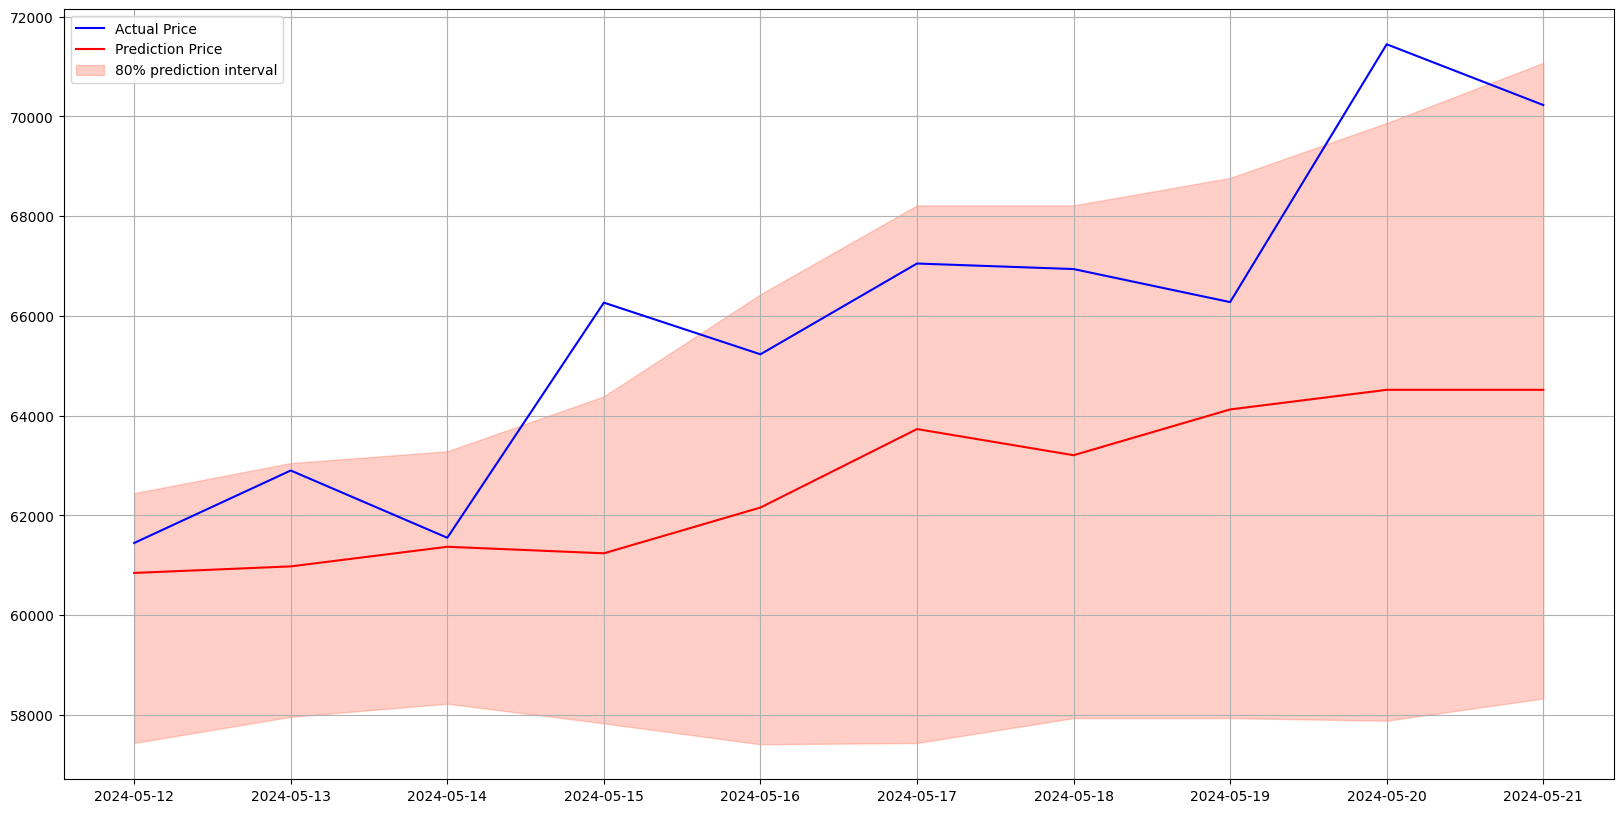

In [15]:
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from chronos import ChronosPipeline
import yfinance as yf

token = "BTC-USD"
token = yf.download(token)
token.to_csv("BTC-USD.csv")


df = pd.read_csv("BTC-USD.csv", index_col="Date", parse_dates=True)
df.dropna(inplace=True)

dias = 10

train_size = int(len(df) - dias)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

#Hacemos las predicciones
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    device_map="cuda",
    torch_dtype=torch.bfloat16,
)

prediction_length = dias
context = torch.tensor(train_df["Close"])
forecast = pipeline.predict(context, prediction_length, num_samples=20)

low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(20,10))
plt.plot(test_df.index, test_df["Close"], label="Actual Price",color="blue")
plt.plot(test_df.index, median, color="red", label="Prediction Price")
plt.fill_between(test_df.index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
list_num_samples = [5,10,15,20,50,100,150,200]

def forecast_with_samples(
        pipeline,
        context,
        prediction_length,
        list_num_samples,
        test_df,
        ):
    for num_sample in list_num_samples:
        forecast = pipeline.predict(context, prediction_length, num_sample)
        low, median, high = np.quantile(forecast[0].numpy(), [0.1,0.5,0.9], axis=0)
        mae = mean_absolute_error(test_df["Close"], median)
        mse = mean_squared_error(test_df["Close"], median)
        print(f"This is sample {num_sample}")
        print(f"MAE={mae}")
        print(f"MSE={mse}")

forecast_values = forecast_with_samples(pipeline,context, prediction_length, list_num_samples, test_df)

10
10
This is sample 5
MAE=4264.59285211034
MSE=29252414.88727381
10
10
This is sample 10
MAE=4143.37933344775
MSE=25138432.61187385
10
10
This is sample 15
MAE=2859.27666890212
MSE=12918457.496021748
10
10
This is sample 20
MAE=4694.153710375006
MSE=29557736.80401387
10
10
This is sample 50
MAE=4523.6733682744
MSE=27610304.46512376
10
10
This is sample 100
MAE=4471.213548177942
MSE=28040731.33904314


OutOfMemoryError: CUDA out of memory. Tried to allocate 152.00 MiB. GPU 0 has a total capacity of 11.00 GiB of which 0 bytes is free. Of the allocated memory 17.41 GiB is allocated by PyTorch, and 201.68 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

list_num_samples = [5, 10, 15, 20, 50, 100, 150, 200]

def forecast_with_samples(pipeline, context, prediction_length, list_num_samples, test_df):
    mae_values = {}
    mse_values = {}
    r2_values = {}
    
    for num_sample in list_num_samples:
        forecast = pipeline.predict(context, prediction_length, num_sample)
        forecast_values = forecast[0].numpy()
        low, median, high = np.quantile(forecast_values, [0.1, 0.5, 0.9], axis=0)
        
        actual_values = test_df["Close"].values[:len(median)]
        
        mae = mean_absolute_error(actual_values, median)
        mse = mean_squared_error(actual_values, median)
        r2 = r2_score(actual_values, median)
        
        print(f"This is sample {num_sample}")
        print(f"MAE: {mae}")
        print(f"MSE: {mse}")
        print(f"R² Score: {r2}")
        
        mae_values[num_sample] = mae
        mse_values[num_sample] = mse
        r2_values[num_sample] = r2
        
     
    
    return mae_values, mse_values, r2_values

# Llamada a la función
mae_values, mse_values, r2_values = forecast_with_samples(pipeline, context, prediction_length, list_num_samples, test_df)


This is sample 5
MAE: 5706.705687380003
MSE: 42305307.305497035
R² Score: -2.966673890317867
This is sample 10
MAE: 5575.567225124765
MSE: 43250046.747776255
R² Score: -3.055255525047076
This is sample 15
MAE: 3765.8782808055084
MSE: 20293476.985381834
R² Score: -0.9027779356473564
This is sample 20
MAE: 4605.153521837518
MSE: 30237184.98309351
R² Score: -1.8351301486365457
This is sample 50
MAE: 5195.2697786101435
MSE: 36964231.00879389
R² Score: -2.4658783816282255
This is sample 100
MAE: 4316.650951888779
MSE: 25490691.056622107
R² Score: -1.3900844858612742
This is sample 150
MAE: 4500.245822552502
MSE: 28247454.023491144
R² Score: -1.6485669406395602
This is sample 200
MAE: 4264.197955168264
MSE: 26080461.750271775
R² Score: -1.4453831743894345


In [23]:
from pathlib import Path
from typing import List, Optional, Union
import pandas as pd
import numpy as np
from gluonts.dataset.arrow import ArrowWriter




def convert_to_arrow(
    path: Union[str, Path],
    time_series: Union[List[np.ndarray], np.ndarray],
    start_times: Optional[Union[List[np.datetime64], np.ndarray]] = None,
    compression: str = "lz4",
):
    if start_times is None:
        # Set an arbitrary start time
        start_times = [np.datetime64("2000-01-01 00:00", "s")] * len(time_series)

    assert len(time_series) == len(start_times)

    dataset = [
        {"start": start, "target": ts} for ts, start in zip(time_series, start_times)
    ]
    ArrowWriter(compression=compression).write_to_file(
        dataset,
        path=path,
    )


if __name__ == "__main__":
    df = pd.read_csv("BTC-USD.csv", index_col="Date", parse_dates=True)
    time_series = [df['Close'].values]
    start_times = [df.index.values[0]]
    
    convert_to_arrow("./bitcoin_prices.arrow", time_series=time_series, start_times=start_times)


In [12]:
import yfinance as yf

tick = "BTC-USD"

token = yf.download(tick)

print(token.type)

[*********************100%%**********************]  1 of 1 completed


AttributeError: 'DataFrame' object has no attribute 'type'